Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple

/mnt/e/workspace/townhall/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transition namedtuple for storing experiences

In [2]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

Assume a shared Q-network for simplicity

In [3]:
class SharedDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SharedDQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        # Output a Q-value for each action
        self.fc3 = nn.Linear(16, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Define replay memory

In [4]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [5]:
class CooperativeAgent:
    def __init__(self, id, grid_size, num_features):
        self.id = id
        self.grid_size = grid_size
        self.num_features = num_features
        self.position = self.random_position()  # Initialize agent position randomly
        self.positions = [self.position]  # Track agent positions
    def random_position(self):
        return (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
    def take_action(self, policy_net):
        # Implementing epsilon-greedy strategy
        epsilon = 0.1  # 10% chance to select random action
        if random.random() < epsilon:
            action = random.randint(0, 3)  # Random action
        else:
            state = torch.tensor(
                self.position, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                # Greedy action based on policy_net
                action = policy_net(state).max(1)[1].item()

        # Update position based on action
        if action == 0 and self.position[1] < self.grid_size - 1:
            self.position = (self.position[0], self.position[1] + 1)
        elif action == 1 and self.position[0] < self.grid_size - 1:
            self.position = (self.position[0] + 1, self.position[1])
        elif action == 2 and self.position[1] > 0:
            self.position = (self.position[0], self.position[1] - 1)
        elif action == 3 and self.position[0] > 0:
            self.position = (self.position[0] - 1, self.position[1])
        self.positions.append(self.position)  # Update the positions list
        return action  # Return the taken action for storing experience
    def calculate_reward(self, targets):
        reward = 0
        for target in targets:
            # Calculate the old and new distances to the target
            old_distance = ((self.positions[-2][0] - target[0]) **
                            2 + (self.positions[-2][1] - target[1]) ** 2) ** 0.5
            new_distance = (
                (self.position[0] - target[0]) ** 2 + (self.position[1] - target[1]) ** 2) ** 0.5

            # Provide a positive reward for moving closer, and a negative reward for moving farther away
            reward += old_distance - new_distance
        return reward

In [6]:
class MultiAgentEnvironment:
    def __init__(self, num_agents, num_targets, grid_size, num_features):
        self.num_agents = num_agents
        self.num_targets = num_targets
        self.grid_size = grid_size
        self.agents = [CooperativeAgent(
            i, grid_size, num_features) for i in range(num_agents)]
        self.targets = [self.random_position() for _ in range(num_targets)]
    def random_position(self):
        return (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
    def step(self, policy_net, memory):
        # Agents take actions
        for agent in self.agents:
            current_position = agent.position  # Store current position
            action = agent.take_action(policy_net)  # Take action
            next_position = agent.position  # Store next position
            reward = agent.calculate_reward(self.targets)  # Calculate reward
            # Collect state transitions and rewards for training
            memory.push(current_position, action, next_position, reward)
    def reset(self):
        # Reset agent positions at the beginning of each episode
        for agent in self.agents:
            agent.position = self.random_position()
            agent.positions = [agent.position]

Visualization

In [7]:
def visualize_environment(environment):
    plt.figure(figsize=(8, 8))
    for agent in environment.agents:
        positions = np.array(agent.positions)
        plt.plot(positions[:, 0], positions[:, 1],
                 label=f'Agent {agent.id}', alpha=0.5)  # Fixed line
    for target in environment.targets:
        plt.scatter(target[0], target[1], marker='x',
                    s=100, c='red', label='Target')
    plt.legend()
    plt.title('Agent Trajectories and Target Positions')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

Training Loop

In [8]:
num_agents = 3
num_targets = 2
grid_size = 10
num_features = 2  # X and Y position
multi_agent_env = MultiAgentEnvironment(
    num_agents, num_targets, grid_size, num_features)
shared_dqn = SharedDQN(input_size=num_features,
                       output_size=4)  # Assume 4 actions
shared_optimizer = optim.RMSprop(shared_dqn.parameters())
shared_memory = ReplayMemory(10000)

In [9]:
num_episodes = 100
num_steps_per_episode = 100
BATCH_SIZE = 64
GAMMA = 0.99

In [10]:
for episode in range(num_episodes):
    multi_agent_env.reset()  # Reset agent positions at the beginning of each episode
    for step in range(num_steps_per_episode):
        multi_agent_env.step(shared_dqn, shared_memory)
        # Train the shared policy network
        if len(shared_memory) >= BATCH_SIZE:
            transitions = shared_memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            state_batch = torch.tensor(batch.state, dtype=torch.float32)
            action_batch = torch.tensor(batch.action, dtype=torch.int64)
            next_state_batch = torch.tensor(
                batch.next_state, dtype=torch.float32)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
            q_values = shared_dqn(state_batch)
            next_q_values = shared_dqn(next_state_batch)
            expected_q_values = reward_batch + GAMMA * next_q_values.max(1)[0]
            loss = F.smooth_l1_loss(q_values.gather(
                1, action_batch.unsqueeze(1)), expected_q_values.unsqueeze(1))
            shared_optimizer.zero_grad()
            loss.backward()
            shared_optimizer.step()

Visualize agent trajectories and target positions

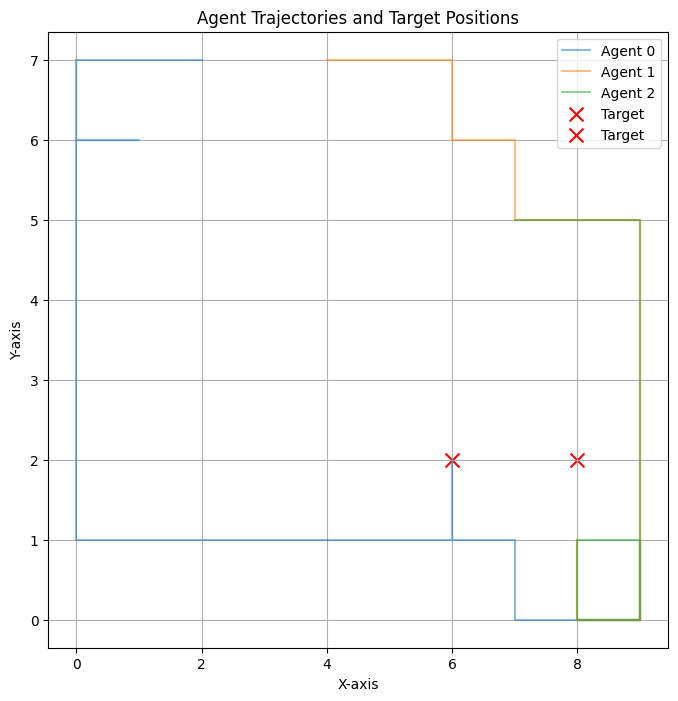

In [11]:
visualize_environment(multi_agent_env)